# Libraries 📚

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
from tensorflow import keras
import time

# IPNYB
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Autoencoder
# Model and performance
import tensorflow as tf
from tensorflow.keras import losses , layers
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer

2023-07-05 13:00:02.044771: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 13:00:02.121700: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-05 13:00:02.123280: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 13:00:03.126579: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Code 💻

## Functions

In [35]:
def load_select_resolution(dx, dy):
        '''
        Selects the resolution of the matrices to load.
        dx: the x resolution
        dy: the y resolution
        return X, y
        '''
        if dx == 0.1 and dy == 0.1:
                # Load matrices from previously generated files
                X_01 = np.load('matrices/X_01.npy')
                y_01 = np.load('matrices/y_01.npy')
                print(f'Matrix shapes -> X: {X_01.shape}, y: {y_01.shape}')
                return X_01, y_01
                        
        elif dx == 0.3 and dy == 0.3:
                # Load matrices from previously generated files
                X_03 = np.load('matrices/X_03.npy')
                y_03 = np.load('matrices/y_03.npy')
                print(f'Matrix shapes -> X: {X_03.shape}, y: {y_03.shape}')
                return X_03, y_03
        
def tts(X, y):
        # Splitting the data into training and testing sets
        # We will use 80% of the data for training and 20% of the data for testing.
        # We will split the training data into training and validation sets.
        # We will use 80% of the training data for training and 20% of the training data for validation.
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
        print(f'Train shapes -> X: {X_train.shape}, y: {y_train.shape}, Val shapes -> X: {X_val.shape}, y: {y_val.shape}, Test shapes -> X: {X_test.shape}, y: {y_test.shape}')
        return X_train, X_val, X_test, y_train, y_val, y_test            
        
def f1_score(precision, recall):
                return 2 * (precision * recall) / (precision + recall)
        
def feed_forward(X_train, X_val, X_test, y_train, y_val, y_test):
        # Normalizing the data
        # We will use the function normalize from keras.utils to normalize the data.
        # We will normalize the data by dividing the data by the maximum value of the data.
        X_train = keras.utils.normalize(X_train, axis=1)
        X_val = keras.utils.normalize(X_val, axis=1)
        X_test = keras.utils.normalize(X_test, axis=1)

        # Reshape the data for a fit forward neural networ
        # Reshape the y data to be a column one-hot encoded vector.
        y_train = keras.utils.to_categorical(y_train, 2)
        y_val = keras.utils.to_categorical(y_val, 2)
        y_test = keras.utils.to_categorical(y_test, 2)

        # Check the number of records
        print('The number of records in the training dataset is', X_train.shape[0])
        print('The number of records in the test dataset is', X_test.shape[0])
        print('The number of records in the validation dataset is', X_val.shape[0])
        print(f"Target training vector: {y_train}") # Show target vector (01 = muon, 10 = antimuon)
        print(f'Train shapes -> X: {X_train.shape}, y: {y_train.shape}, Val shapes -> X: {X_val.shape}, y: {y_val.shape}, Test shapes -> X: {X_test.shape}, y: {y_test.shape}')

        model = keras.Sequential([
                keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
                keras.layers.Dense(2, activation='softmax')
                ])

        # Compile the model and build F1 score metric
        model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                #metrics=['accuracy'])
                metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy'])#, f1_score])

        # Save the model
        model.save('models/feed_forward.h5')
        
        # Print the model summary
        print(model.summary())
        
        # Time the training
        start = time.time()
        history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
        end = time.time()
        print('Training time:', end - start)
        
        # Plotting the training and validation loss, accuracy and F1 score
        fig, axs = plt.subplots(1, 2, figsize=(20, 7))
        axs[0].plot(history.history['loss'], label='Training loss')
        axs[0].plot(history.history['val_loss'], label='Validation loss')
        axs[0].set_title('Training and validation loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[1].plot(history.history['accuracy'], label='Training accuracy')
        axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
        axs[1].set_title('Training and validation accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        #axs[2].plot(history.history['f1_score'], label='Training F1 score')
        #axs[2].plot(history.history['val_f1_score'], label='Validation F1 score')
        #axs[2].set_title('Training and validation F1 score')
        #axs[2].set_xlabel('Epoch')
        #axs[2].set_ylabel('F1 score')
        #axs[2].legend()
        plt.show()
        
        return X_train, X_val, X_test, y_train, y_val, y_test, model

def cnn_pad(X_train, X_val, X_test, y_train, y_val, y_test):
        # We want to bring the dimension from each matrix from 21,15,2 to 21,21,2 or 7,5,2 to 7,7,2 depending on the resolution.
        # We will use numpy.pad to pad the matrices with zeros.
        # We will pad the matrices with zeros in the third dimension (columns) and calculate the necessary padding for each matrix.
        X_train = np.pad(X_train, ((0,0),(0,0),(0, X_train.shape[1]-X_train.shape[2]), (0,0)), mode='constant')
        X_val = np.pad(X_val, ((0,0),(0,0),(0, X_val.shape[1]-X_val.shape[2]), (0,0)), mode='constant')
        X_test = np.pad(X_test, ((0,0),(0,0),(0, X_test.shape[1]-X_test.shape[2]), (0,0)), mode='constant')

        # Normalizing the data
        # We will use the function normalize from keras.utils to normalize the data.
        # We will normalize the data by dividing the data by the maximum value of the data.
        X_train = keras.utils.normalize(X_train, axis=1)
        X_val = keras.utils.normalize(X_val, axis=1)
        X_test = keras.utils.normalize(X_test, axis=1)

        # Reshape the y data to be a column one-hot encoded vector.
        y_train = keras.utils.to_categorical(y_train, 2)
        y_val = keras.utils.to_categorical(y_val, 2)
        y_test = keras.utils.to_categorical(y_test, 2)
        
        # Check the number of records
        print('The number of records in the training dataset is', X_train.shape[0])
        print('The number of records in the test dataset is', X_test.shape[0])
        print('The number of records in the validation dataset is', X_val.shape[0])
        print(f"Target training vector: {y_train}") # Show target vector (01 = muon, 10 = antimuon)
        print(f'Train shapes -> X: {X_train.shape}, y: {y_train.shape}, Val shapes -> X: {X_val.shape}, y: {y_val.shape}, Test shapes -> X: {X_test.shape}, y: {y_test.shape}')
        
        kernel_size = (3, 3)
        pool_size = (2, 2)
        # Create the CNN
        model = keras.models.Sequential()
        model.add(keras.layers.Conv2D(32, kernel_size=kernel_size, strides=(1,1), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
        model.add(keras.layers.Conv2D(64, kernel_size=kernel_size, strides=(1,1), activation='relu'))
        model.add(keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2,2)))
        model.add(keras.layers.Conv2D(128, kernel_size=kernel_size, strides=(1,1), activation='relu'))
        model.add(keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2,2)))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))
        
        # Compile the model and build F1 score metric
        model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                #metrics=['accuracy'])
                metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy'])#, f1_score])

        # Save the model
        model.save('models/cnn_pad.h5')

        # Print the model summary
        print(model.summary())

        # Time the training
        start = time.time()
        history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
        end = time.time()
        print('Training time:', end - start)
        
        # Plotting the training and validation loss, accuracy and F1 score
        fig, axs = plt.subplots(1, 2, figsize=(20, 7))
        axs[0].plot(history.history['loss'], label='Training loss')
        axs[0].plot(history.history['val_loss'], label='Validation loss')
        axs[0].set_title('Training and validation loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[1].plot(history.history['accuracy'], label='Training accuracy')
        axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
        axs[1].set_title('Training and validation accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        #axs[2].plot(history.history['f1_score'], label='Training F1 score')
        #axs[2].plot(history.history['val_f1_score'], label='Validation F1 score')
        #axs[2].set_title('Training and validation F1 score')
        #axs[2].set_xlabel('Epoch')
        #axs[2].set_ylabel('F1 score')
        #axs[2].legend()
        plt.show()
        
        return X_train, X_val, X_test, y_train, y_val, y_test, model

def cnn_1d(X,y):
        # Reshape X to fit the input of the 1D CNN
        X = X.reshape((X.shape[0], -1, 1))

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

        X_train = keras.utils.normalize(X_train, axis=1)
        X_val = keras.utils.normalize(X_val, axis=1)
        X_test = keras.utils.normalize(X_test, axis=1)
        
        # Check the number of records
        print('The number of records in the training dataset is', X_train.shape[0])
        print('The number of records in the test dataset is', X_test.shape[0])
        print('The number of records in the validation dataset is', X_val.shape[0])
        print(f"Target training vector: {y_train}") # Show target vector (01 = muon, 10 = antimuon)
        print(f'Train shapes -> X: {X_train.shape}, y: {y_train.shape}, Val shapes -> X: {X_val.shape}, y: {y_val.shape}, Test shapes -> X: {X_test.shape}, y: {y_test.shape}')
        
        # 1D CNN
        model = keras.models.Sequential([
                keras.layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
                keras.layers.MaxPooling1D(2),
                keras.layers.Conv1D(64, 3, activation='relu'),
                keras.layers.MaxPooling1D(2),
                keras.layers.Conv1D(128, 3, activation='relu'),
                keras.layers.MaxPooling1D(2),
                keras.layers.Flatten(),
                keras.layers.Dense(128, activation='relu'),
                keras.layers.Dense(2, activation='softmax')
        ])

        model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy'])#, f1_score])

        # Save the model
        model.save('models/cnn_1d.h5')
        
        # Print the model summary
        print(model.summary())

        # Time the training
        start = time.time()
        history = model.fit(X_train, keras.utils.to_categorical(y_train), epochs=30, validation_data=(X_val, keras.utils.to_categorical(y_val)))
        end = time.time()
        print('Training time [s]:', end - start)
        
                # Plotting the training and validation loss, accuracy and F1 score
        fig, axs = plt.subplots(1, 2, figsize=(20, 7))
        axs[0].plot(history.history['loss'], label='Training loss')
        axs[0].plot(history.history['val_loss'], label='Validation loss')
        axs[0].set_title('Training and validation loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[1].plot(history.history['accuracy'], label='Training accuracy')
        axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
        axs[1].set_title('Training and validation accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        #axs[2].plot(history.history['f1_score'], label='Training F1 score')
        #axs[2].plot(history.history['val_f1_score'], label='Validation F1 score')
        #axs[2].set_title('Training and validation F1 score')
        #axs[2].set_xlabel('Epoch')
        #axs[2].set_ylabel('F1 score')
        #axs[2].legend()
        plt.show()
        
        return X_train, X_val, X_test, y_train, y_val, y_test, model

def cnn_32(X_train, X_val, X_test, y_train, y_val, y_test):
        # Making sure that the data is in the correct format for the CNN
        # Images are not square, so we will proportionally resize the images to be square.
        # Dimensions to resize the images to
        ROWS = 32
        COLS = 32

        # Resizing the images
        X_train = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_train])
        X_val = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_val])
        X_test = np.array([keras.preprocessing.image.smart_resize(image, (ROWS, COLS)) for image in X_test])

        # Normalizing the data
        # We will normalize the data by dividing the data by the maximum value of the data.
        X_train = keras.utils.normalize(X_train, axis=1)
        X_val = keras.utils.normalize(X_val, axis=1)
        X_test = keras.utils.normalize(X_test, axis=1)

        # Reshaping the target data to have 2 dimensions (one-hot encoding)
        y_train = keras.utils.to_categorical(y_train, 2)
        y_val = keras.utils.to_categorical(y_val, 2)
        y_test = keras.utils.to_categorical(y_test, 2)
        
        # Check the number of records
        print('The number of records in the training dataset is', X_train.shape[0])
        print('The number of records in the test dataset is', X_test.shape[0])
        print('The number of records in the validation dataset is', X_val.shape[0])
        print(f"Target training vector: {y_train}") # Show target vector (01 = muon, 10 = antimuon)
        print(f'Train shapes -> X: {X_train.shape}, y: {y_train.shape}, Val shapes -> X: {X_val.shape}, y: {y_val.shape}, Test shapes -> X: {X_test.shape}, y: {y_test.shape}')
        
        kernel_size = (3, 3)
        pool_size = (2, 2)
        # Create the CNN
        model = keras.models.Sequential()
        model.add(keras.layers.Conv2D(32, kernel_size=kernel_size, strides=(1,1), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
        model.add(keras.layers.Conv2D(64, kernel_size=kernel_size, strides=(1,1), activation='relu'))
        model.add(keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2,2)))
        model.add(keras.layers.Conv2D(128, kernel_size=kernel_size, strides=(1,1), activation='relu'))
        model.add(keras.layers.MaxPooling2D(pool_size=pool_size, strides=(2,2)))
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dense(2, activation='softmax'))

        # Compile the CNN
        model.compile(optimizer='adam',
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
                #metrics=[keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(), keras.metrics.AUC(curve='ROC'), 'accuracy', f1_score])

        # Save the model
        model.save('models/cnn_32.h5')
        
        # Print the model summary
        print(model.summary())

        # Time the training
        start = time.time()
        history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
        end = time.time()
        print('Training time:', end - start)
        
        # Plotting the training and validation loss, accuracy and F1 score
        fig, axs = plt.subplots(1, 2, figsize=(20, 7))
        axs[0].plot(history.history['loss'], label='Training loss')
        axs[0].plot(history.history['val_loss'], label='Validation loss')
        axs[0].set_title('Training and validation loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()
        axs[1].plot(history.history['accuracy'], label='Training accuracy')
        axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
        axs[1].set_title('Training and validation accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
        #axs[2].plot(history.history['f1_score'], label='Training F1 score')
        #axs[2].plot(history.history['val_f1_score'], label='Validation F1 score')
        #axs[2].set_title('Training and validation F1 score')
        #axs[2].set_xlabel('Epoch')
        #axs[2].set_ylabel('F1 score')
        #axs[2].legend()
        plt.show()
        
        return X_train, X_val, X_test, y_train, y_val, y_test, model
        

## Load data and select resolution

In [36]:
X, y = load_select_resolution(0.1, 0.1)

Matrix shapes -> X: (10233, 21, 15, 2), y: (10233,)


## Feed Forward NN

Train shapes -> X: (6548, 21, 15, 2), y: (6548,), Val shapes -> X: (1638, 21, 15, 2), y: (1638,), Test shapes -> X: (2047, 21, 15, 2), y: (2047,)
The number of records in the training dataset is 6548
The number of records in the test dataset is 2047
The number of records in the validation dataset is 1638
Target training vector: [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Train shapes -> X: (6548, 21, 15, 2), y: (6548, 2), Val shapes -> X: (1638, 21, 15, 2), y: (1638, 2), Test shapes -> X: (2047, 21, 15, 2), y: (2047, 2)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 630)               0         
                                                                 
 dense (Dense)               (None, 2)                 1262      
                                                                 
Total params: 1,262
Trainable params: 1,26

2023-07-05 13:00:05.224486: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-05 13:00:05.225106: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


205/205 [==============================] - 2s 5ms/step - loss: 0.6965 - precision: 0.4991 - recall: 0.4991 - auc: 0.4976 - auc_1: 0.4976 - accuracy: 0.4991 - val_loss: 0.6964 - val_precision: 0.4884 - val_recall: 0.4884 - val_auc: 0.4942 - val_auc_1: 0.4942 - val_accuracy: 0.4884
Epoch 2/30
205/205 [==============================] - 1s 3ms/step - loss: 0.6909 - precision: 0.5249 - recall: 0.5249 - auc: 0.5351 - auc_1: 0.5351 - accuracy: 0.5249 - val_loss: 0.6970 - val_precision: 0.4933 - val_recall: 0.4933 - val_auc: 0.4922 - val_auc_1: 0.4922 - val_accuracy: 0.4933
Epoch 3/30
205/205 [==============================] - 1s 3ms/step - loss: 0.6870 - precision: 0.5440 - recall: 0.5440 - auc: 0.5591 - auc_1: 0.5591 - accuracy: 0.5440 - val_loss: 0.6959 - val_precision: 0.5067 - val_recall: 0.5067 - val_auc: 0.5074 - val_auc_1: 0.5074 - val_accuracy: 0.5067
Epoch 4/30
205/205 [==============================] - 1s 3ms/step - loss: 0.6841 - precision: 0.5504 - recall: 0.5504 - auc: 0.5734 - a

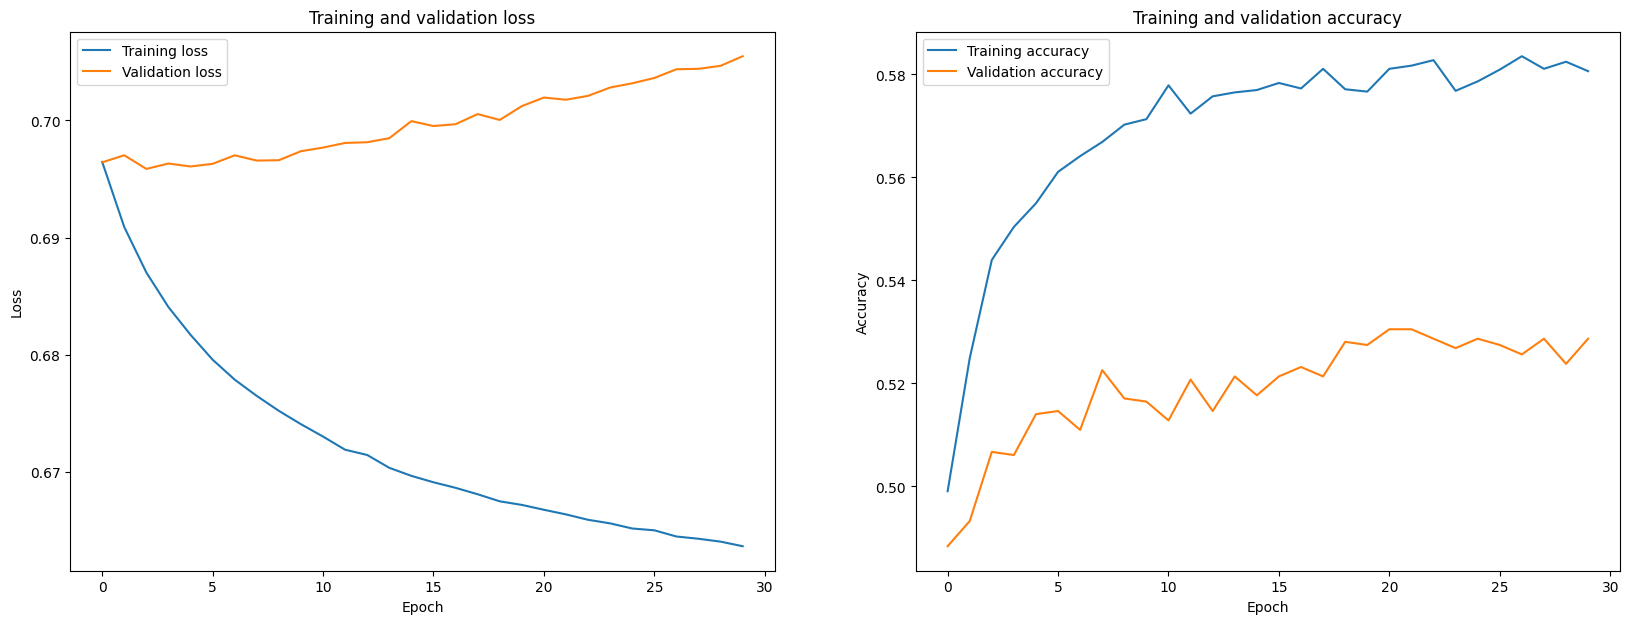

In [4]:
X_train, X_val, X_test, y_train, y_val, y_test = tts(X, y)
X_train, X_val, X_test, y_train, y_val, y_test, ff_model = feed_forward(X_train, X_val, X_test, y_train, y_val, y_test)

In [5]:
# Evaluate the model
#model = keras.models.load_model('models/feed_forward_NN.h5')
#keras.utils.plot_model(model, 'models/feed_forward_NN.png', show_shapes=True)
ff_model.evaluate(X_test, y_test)

64/64 [==============================] - 0s 2ms/step - loss: 0.7114 - precision: 0.5217 - recall: 0.5217 - auc: 0.5224 - auc_1: 0.5224 - accuracy: 0.5217


[0.7114185094833374,
 0.52173912525177,
 0.52173912525177,
 0.52239990234375,
 0.52239990234375,
 0.52173912525177]

In [6]:
# Make predictions
predictions = ff_model.predict(X_test)
print(predictions)

64/64 [==============================] - 0s 2ms/step
[[0.7391766  0.26082346]
 [0.39712793 0.602872  ]
 [0.707878   0.29212198]
 ...
 [0.49342263 0.50657743]
 [0.5337853  0.46621463]
 [0.39700556 0.6029944 ]]


## CNN with padding

Train shapes -> X: (6548, 21, 15, 2), y: (6548,), Val shapes -> X: (1638, 21, 15, 2), y: (1638,), Test shapes -> X: (2047, 21, 15, 2), y: (2047,)


The number of records in the training dataset is 6548
The number of records in the test dataset is 2047
The number of records in the validation dataset is 1638
Target training vector: [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Train shapes -> X: (6548, 21, 21, 2), y: (6548, 2), Val shapes -> X: (1638, 21, 21, 2), y: (1638, 2), Test shapes -> X: (2047, 21, 21, 2), y: (2047, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 19, 32)        608       
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 64)         0         
 )                                                               
                                                      

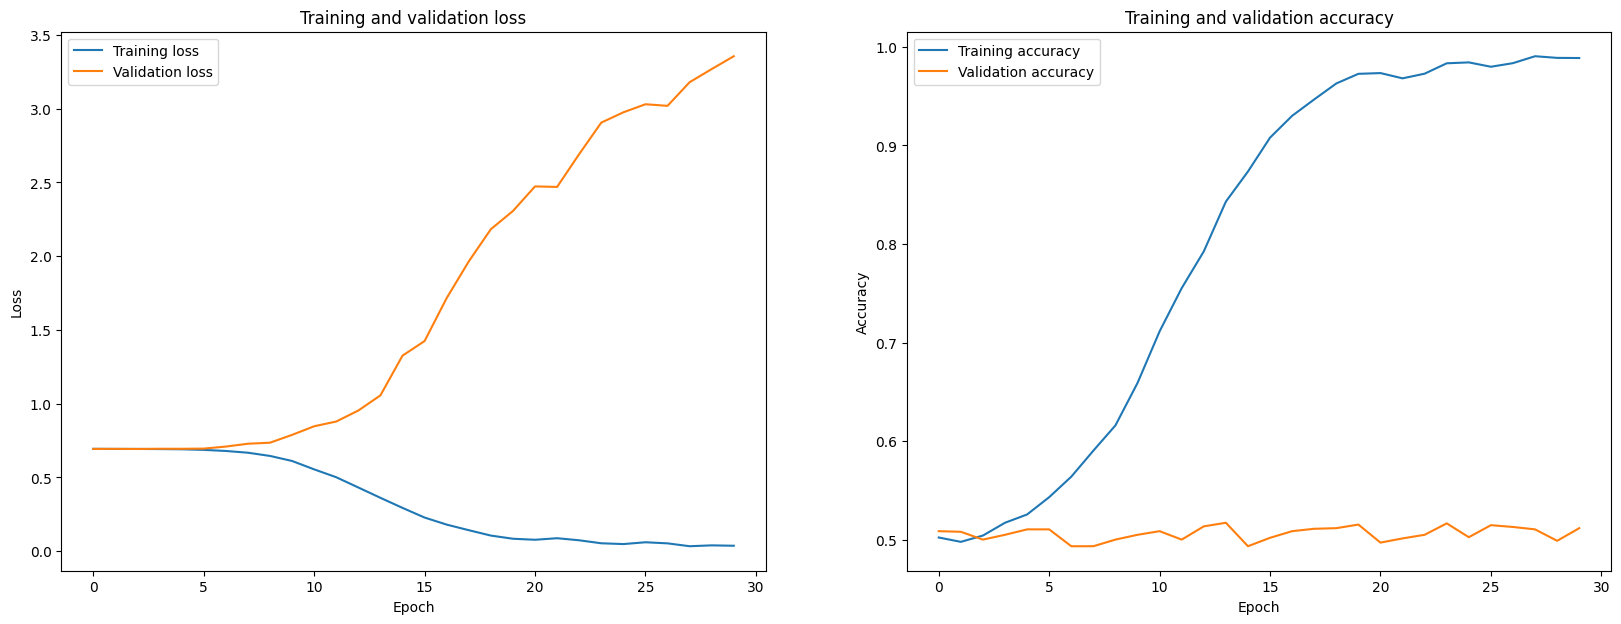

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = tts(X, y)
X_train, X_val, X_test, y_train, y_val, y_test, cnn_pad_model = cnn_pad(X_train, X_val, X_test, y_train, y_val, y_test)

## 1D-CNN

The number of records in the training dataset is 6548
The number of records in the test dataset is 2047
The number of records in the validation dataset is 1638
Target training vector: [0. 1. 0. ... 0. 1. 1.]
Train shapes -> X: (6548, 630, 1), y: (6548,), Val shapes -> X: (1638, 630, 1), y: (1638,), Test shapes -> X: (2047, 630, 1), y: (2047,)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 628, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 314, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 312, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15

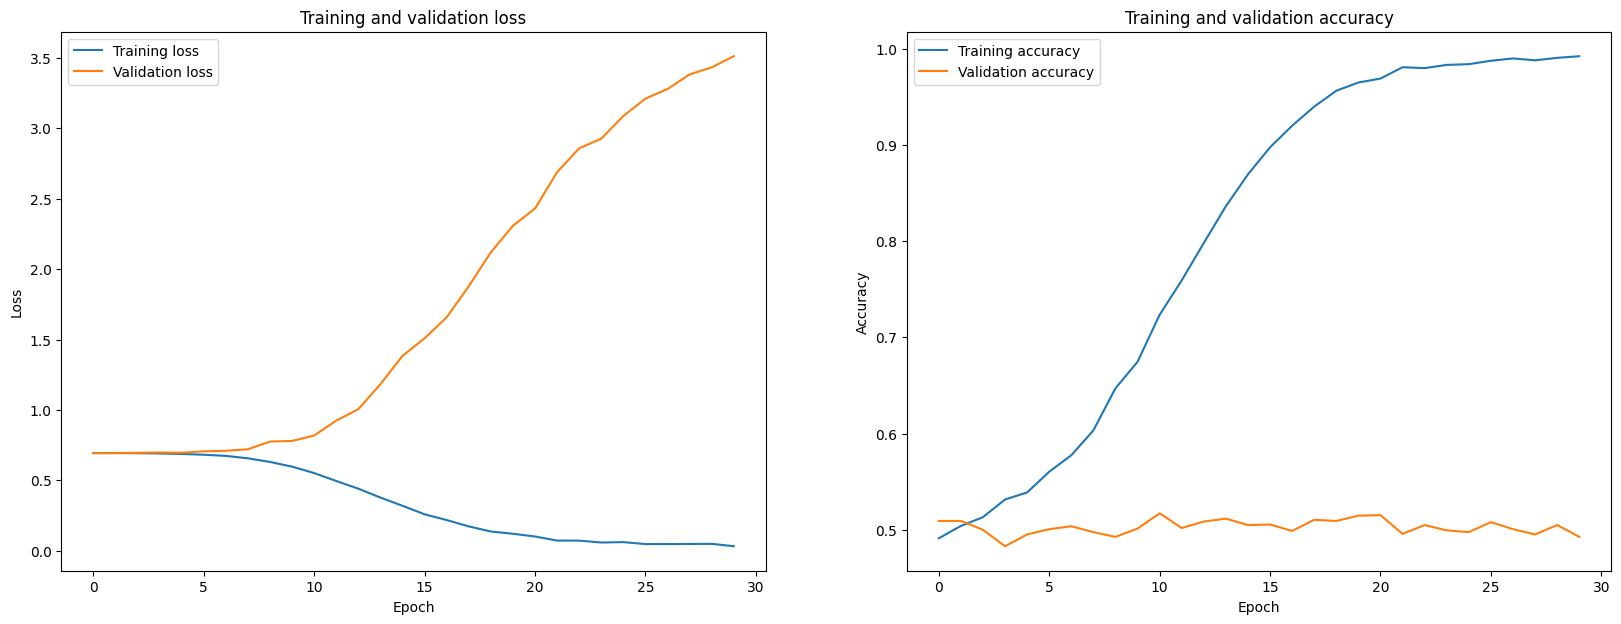

In [8]:
#X_train, X_val, X_test, y_train, y_val, y_test = tts(X, y)
X_train, X_val, X_test, y_train, y_val, y_test, cnn_1d = cnn_1d(X,y)

## Resized 32x32 image CNN

Train shapes -> X: (6548, 21, 15, 2), y: (6548,), Val shapes -> X: (1638, 21, 15, 2), y: (1638,), Test shapes -> X: (2047, 21, 15, 2), y: (2047,)
The number of records in the training dataset is 6548
The number of records in the test dataset is 2047
The number of records in the validation dataset is 1638
Target training vector: [[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Train shapes -> X: (6548, 21, 21, 2), y: (6548, 2), Val shapes -> X: (1638, 21, 21, 2), y: (1638, 2), Test shapes -> X: (2047, 21, 21, 2), y: (2047, 2)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 19, 19, 32)        608       
                                                                 
 conv2d_34 (Conv2D)          (None, 17, 17, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 8,

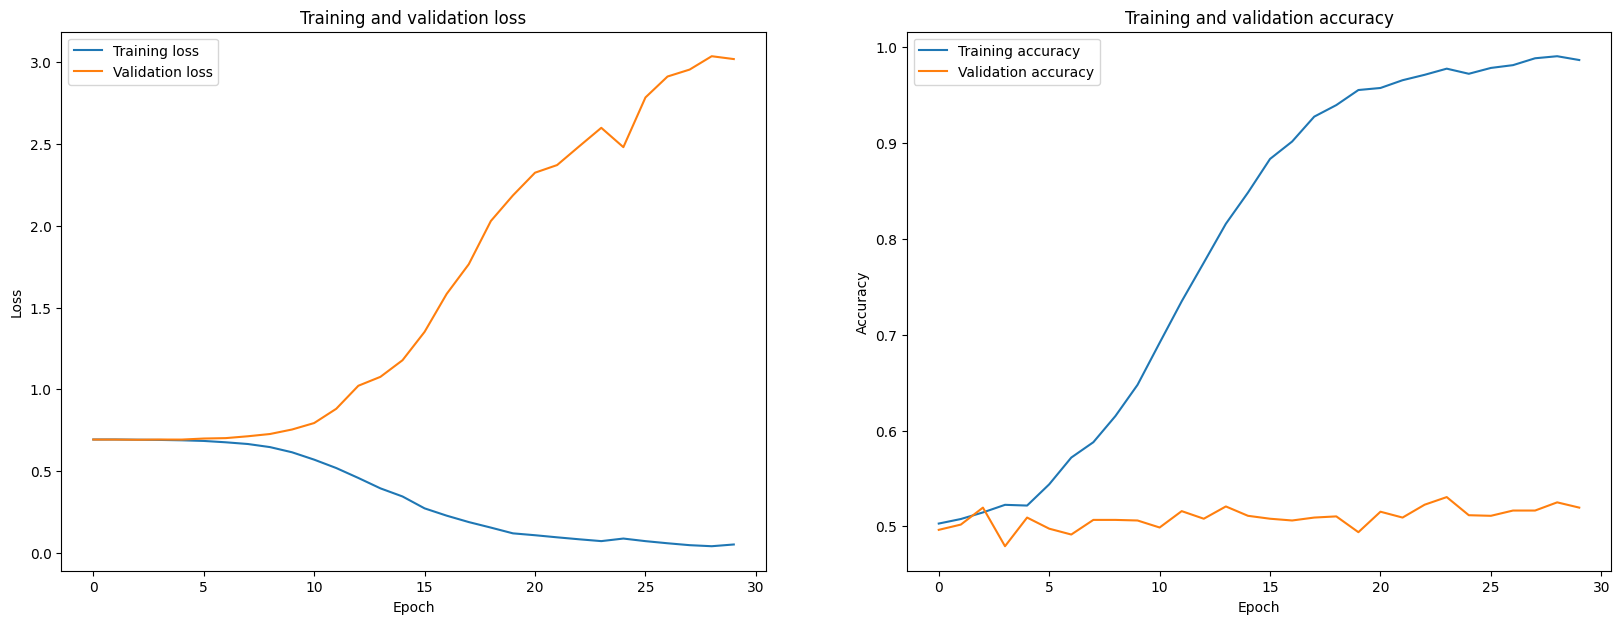

In [37]:
X_train, X_val, X_test, y_train, y_val, y_test = tts(X, y)
X_train, X_val, X_test, y_train, y_val, y_test, cnn_pad_model = cnn_pad(X_train, X_val, X_test, y_train, y_val, y_test)

## Load data and select resolution

In [38]:
X, y = load_select_resolution(0.3, 0.3)

Matrix shapes -> X: (10167, 7, 5, 2), y: (10167,)


## Feed Forward NN

Train shapes -> X: (6506, 7, 5, 2), y: (6506,), Val shapes -> X: (1627, 7, 5, 2), y: (1627,), Test shapes -> X: (2034, 7, 5, 2), y: (2034,)
The number of records in the training dataset is 6506
The number of records in the test dataset is 2034
The number of records in the validation dataset is 1627
Target training vector: [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Train shapes -> X: (6506, 7, 5, 2), y: (6506, 2), Val shapes -> X: (1627, 7, 5, 2), y: (1627, 2), Test shapes -> X: (2034, 7, 5, 2), y: (2034, 2)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 70)                0         
                                                                 
 dense_7 (Dense)             (None, 2)                 142       
                                                                 


Total params: 142
Trainable params: 142
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
204/204 [==============================] - 2s 4ms/step - loss: 0.7069 - precision_4: 0.5052 - recall_4: 0.5052 - auc_8: 0.5041 - auc_9: 0.5041 - accuracy: 0.5052 - val_loss: 0.7015 - val_precision_4: 0.4997 - val_recall_4: 0.4997 - val_auc_8: 0.5055 - val_auc_9: 0.5055 - val_accuracy: 0.4997
Epoch 2/30
204/204 [==============================] - 1s 3ms/step - loss: 0.6996 - precision_4: 0.5028 - recall_4: 0.5028 - auc_8: 0.5069 - auc_9: 0.5069 - accuracy: 0.5028 - val_loss: 0.6979 - val_precision_4: 0.4880 - val_recall_4: 0.4880 - val_auc_8: 0.5052 - val_auc_9: 0.5052 - val_accuracy: 0.4880
Epoch 3/30
204/204 [==============================] - 1s 3ms/step - loss: 0.6966 - precision_4: 0.5011 - recall_4: 0.5011 - auc_8: 0.5104 - auc_9: 0.5104 - accuracy: 0.5011 - val_loss: 0.6962 - val_precision_4: 0.4985 - val_recall_4: 0.4985 - val_auc_8: 0.5

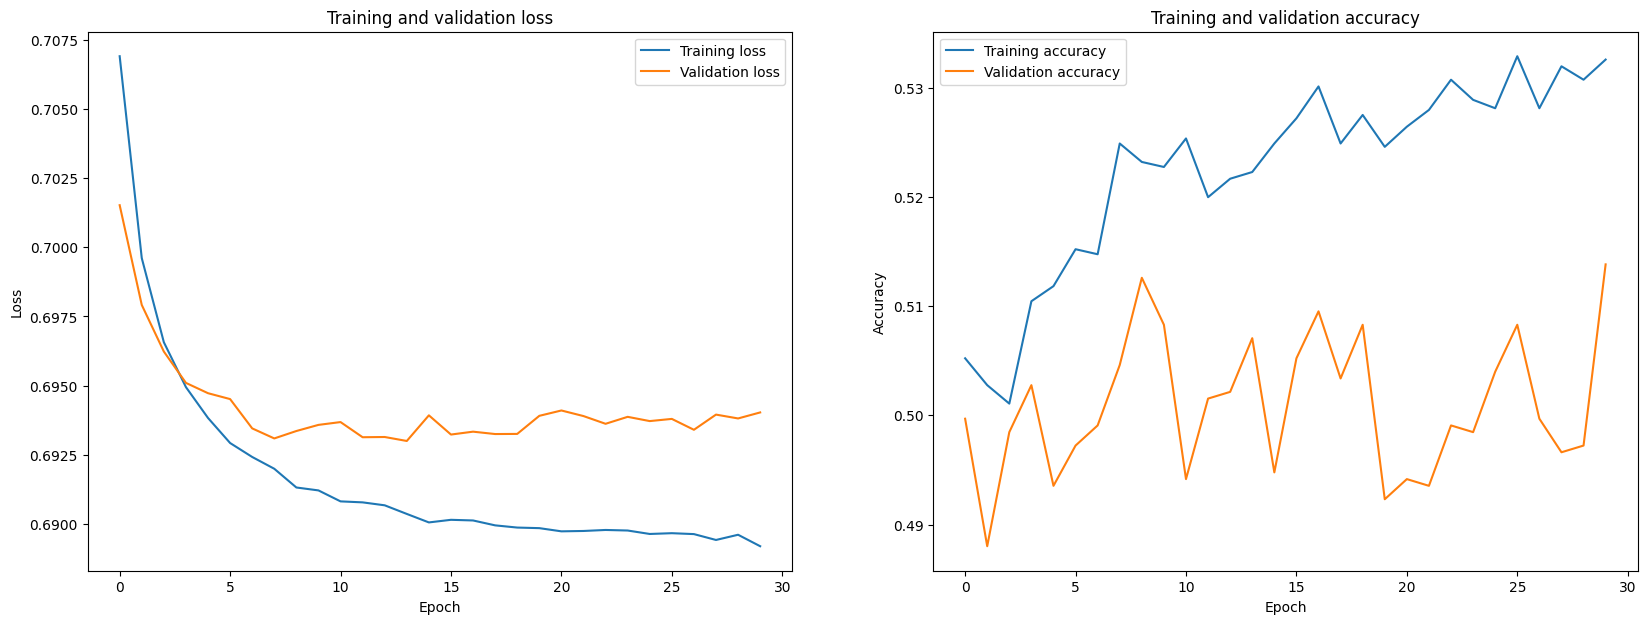

In [11]:
X_train, X_val, X_test, y_train, y_val, y_test = tts(X, y)
X_train, X_val, X_test, y_train, y_val, y_test, ff_model = feed_forward(X_train, X_val, X_test, y_train, y_val, y_test)

In [12]:
# Evaluate the model
#model = keras.models.load_model('models/feed_forward_NN.h5')
#keras.utils.plot_model(model, 'models/feed_forward_NN.png', show_shapes=True)
ff_model.evaluate(X_test, y_test)

 1/64 [..............................] - ETA: 1s - loss: 0.6820 - precision_4: 0.5312 - recall_4: 0.5312 - auc_8: 0.5898 - auc_9: 0.5898 - accuracy: 0.5312

64/64 [==============================] - 0s 2ms/step - loss: 0.6947 - precision_4: 0.5084 - recall_4: 0.5084 - auc_8: 0.5115 - auc_9: 0.5115 - accuracy: 0.5084


[0.6946929693222046,
 0.5083579421043396,
 0.5083579421043396,
 0.5115289688110352,
 0.5115289688110352,
 0.5083579421043396]

In [13]:
# Make predictions
predictions = ff_model.predict(X_test)
print(predictions)

64/64 [==============================] - 0s 1ms/step
[[0.43528318 0.5647169 ]
 [0.4911997  0.5088003 ]
 [0.46451068 0.53548926]
 ...
 [0.45557848 0.5444215 ]
 [0.51856524 0.4814348 ]
 [0.47879156 0.52120835]]


In [14]:
# Plot the confusion matrix
plt.figure(figsize=(10, 10))


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

## CNN with padding

In [39]:
X_train, X_val, X_test, y_train, y_val, y_test = tts(X, y)
X_train, X_val, X_test, y_train, y_val, y_test = cnn_pad(X_train, X_val, X_test, y_train, y_val, y_test)

Train shapes -> X: (6506, 7, 5, 2), y: (6506,), Val shapes -> X: (1627, 7, 5, 2), y: (1627,), Test shapes -> X: (2034, 7, 5, 2), y: (2034,)
The number of records in the training dataset is 6506
The number of records in the test dataset is 2034
The number of records in the validation dataset is 1627
Target training vector: [[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Train shapes -> X: (6506, 7, 7, 2), y: (6506, 2), Val shapes -> X: (1627, 7, 7, 2), y: (1627, 2), Test shapes -> X: (2034, 7, 7, 2), y: (2034, 2)


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_38. Consider increasing the input size. Received input shape [None, 1, 1, 64] which would produce output shape with a zero or negative value in a dimension.

## 1D-CNN

The number of records in the training dataset is 6506
The number of records in the test dataset is 2034
The number of records in the validation dataset is 1627
Target training vector: [0. 1. 1. ... 0. 1. 0.]
Train shapes -> X: (6506, 70, 1), y: (6506,), Val shapes -> X: (1627, 70, 1), y: (1627,), Test shapes -> X: (2034, 70, 1), y: (2034,)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 68, 32)            128       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 34, 32)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 32, 64)            6208      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 16, 6

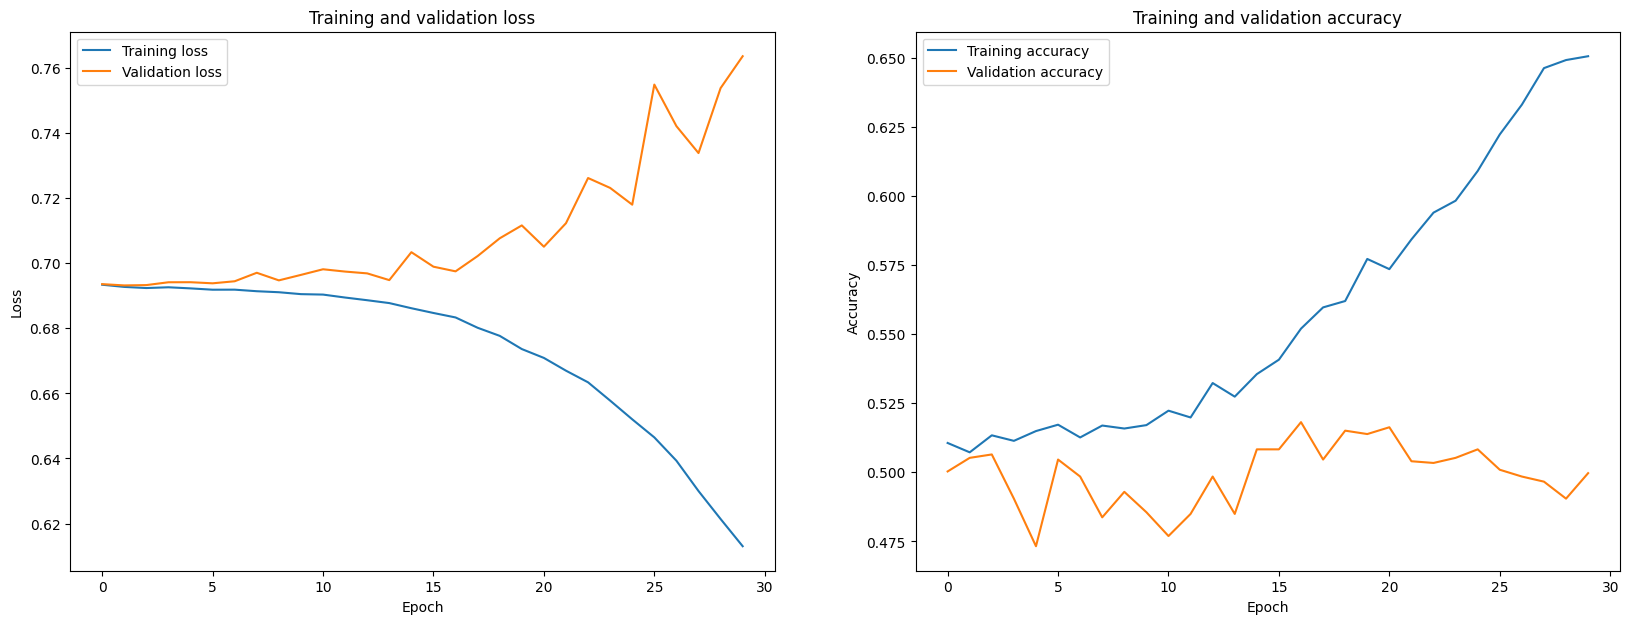

In [23]:
#X_train, X_val, X_test, y_train, y_val, y_test = tts(X, y)
X_train, X_val, X_test, y_train, y_val, y_test, cnn_1d = cnn_1d(X,y)

## Resized 32x32 image CNN

In [40]:
X_train, X_val, X_test, y_train, y_val, y_test = tts(X, y)
X_train, X_val, X_test, y_train, y_val, y_test, cnn_pad_model = cnn_pad(X_train, X_val, X_test, y_train, y_val, y_test)

Train shapes -> X: (6506, 7, 5, 2), y: (6506,), Val shapes -> X: (1627, 7, 5, 2), y: (1627,), Test shapes -> X: (2034, 7, 5, 2), y: (2034,)
The number of records in the training dataset is 6506
The number of records in the test dataset is 2034
The number of records in the validation dataset is 1627
Target training vector: [[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
Train shapes -> X: (6506, 7, 7, 2), y: (6506, 2), Val shapes -> X: (1627, 7, 7, 2), y: (1627, 2), Test shapes -> X: (2034, 7, 7, 2), y: (2034, 2)


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv2d_41. Consider increasing the input size. Received input shape [None, 1, 1, 64] which would produce output shape with a zero or negative value in a dimension.